In [1]:
!pip install --upgrade "jax[cuda11_local]" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install diffrax
!pip install git+https://github.com/deepmind/dm-haiku

import logging
logger = logging.getLogger()
class CheckTypesFilter(logging.Filter):
    def filter(self, record):
        return "check_types" not in record.getMessage()
logger.addFilter(CheckTypesFilter())

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.3/188.3 MB 7.0 MB/s eta 0:00:00
  Created wheel for jax: filename=jax-0.4.13-py3-none-any.whl size=1518707 sha256=141237a539bc18f27d2264ed8aa9f5d8ab3792b5d6846961e1c502b095247e3e
  Stored in directory: /root/.cache/pip/wheels/f3/7a/25/f297f69029b5e4064e4736a0c4b3996a44cc27781c120bcb99
Successfully built jax
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.10+cuda11.cudnn86
    Uninstalling jaxlib-0.4.10+cuda11.cudnn86:
      Successfully uninstalled jaxlib-0.4.10+cuda11.cudnn86
  Attempting uninstall: jax
    Found existing installation: jax 0.4.10
    Uninstalling jax-0.4.10:
      Successfully uninstalled jax-0.4.10


In [2]:
import sys
from google.colab import drive
drive.mount('/content/drive')

abs_path = '/content/drive/My Drive/2023_hackathon/'

sys.path.insert(1,'/content/drive/My Drive/2023_hackathon/cosmo_package_from_Quarks2CosmosDataChallenge')

Mounted at /content/drive


In [3]:
# drive.mount("/content/drive", force_remount=True)

In [4]:
!ls "/content/drive/My Drive/2023_hackathon/cosmo_package_from_Quarks2CosmosDataChallenge"

convdae.py  flow.py  normalization.py  __pycache__


In [5]:
%pylab inline
import jax
import jax.numpy as jnp
from tensorflow_probability.substrates import jax as tfp
from diffrax import diffeqsolve, ControlTerm, Euler, MultiTerm, ODETerm, SaveAt, VirtualBrownianTree, ReversibleHeun
from scipy.integrate import simps
tfd = tfp.distributions
tfb = tfp.bijectors
import pickle

import haiku
import haiku as hk
import sys

# from https://github.com/EiffL/Quarks2CosmosDataChallenge/blob/4aa57a4a52c6987de348cb8172039564ae49d111/quarks2cosmos/models/normalization.py#L149
# uploaded to google drive
from convdae import SmallUResNet
from normalization import SNParamsTree

Populating the interactive namespace from numpy and matplotlib


In [6]:
def load_denoising_model(path):

    with open(path, 'rb') as handle:
        params, state, opt_state = pickle.load(handle)

    return params, state, opt_state

In [7]:
n_size = 128
n_channels = 1

In [8]:
def generate_array_like(y):
    num_axes = y.ndim
    shape = tuple([1 for _ in range(num_axes)])
    return jnp.zeros(shape)

In [9]:
generate_array_like(jnp.ones((2,3,2))).shape

(1, 1, 1)

In [10]:
# print(y.shape, s.reshape(generate_array_like(y)))
# score, _ = model.apply(params, state, None, y, s.reshape(generate_array_like(y)), is_training=False)

In [11]:
def score_fn_denoiser(y, s, model, params, state):

    score, _ = model.apply(params, state, None, y, s.reshape((-1,1,1,1)), is_training=False)

    return score

In [12]:
filepath = abs_path + './model/model-9000.pckl'
params, state, opt_state = load_denoising_model(filepath)

model = hk.transform_with_state(lambda x, sigma, is_training=False: SmallUResNet()(x, sigma, is_training))

In [63]:
s_init = jnp.ones((1))
x = jax.random.normal(shape = (1, 128, 128, n_channels), key=jax.random.PRNGKey(13))
out_x = score_fn_denoiser(x, s_init, model, params, state)

print(out_x.shape)

(1, 128, 128, 1)


In [14]:
# not used at the moment
# def make_likelihood(sigma=0.):
#     """
#     Returns a mixture of Gaussians, convolved with a Gaussian of specified sigma
#     """

#     return tfd.Normal(2.5, jnp.sqrt(0.1**2 +sigma**2) )


In [15]:
def score_fn(t,x, model, params, state, pure_prior = True):
    if(pure_prior == False):
        return 1
    else:
        return score_fn_denoiser(x, t, model, params, state)

# Sampling at fixed time

In [46]:
t0, t1 = 2., 0.
s_init = jnp.ones((1))

drift = lambda t, y, args: - 0.5 * score_fn(s_init, y, model, params, state)
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()

@jax.jit
@jax.vmap
def get_samples(y, seed):

    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
    terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))

    return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000)

In [47]:
n_samples = 3

initial_samples = jax.random.normal(shape = (n_samples, 1, n_size, n_size, n_channels,), key=jax.random.PRNGKey(13)) # * 1e-5
# initial_samples = jax.random.normal(shape = (n_samples, n_size, n_size, n_channels,), key=jax.random.PRNGKey(13)) not sure what to use here
solution = get_samples(
    initial_samples,
    jax.random.split(jax.random.PRNGKey(3), n_samples)
)
res = solution.ys[0]

In [52]:
solution

Solution(
  t0=f32[3],
  t1=f32[3],
  ts=f32[3,1],
  ys=f32[3,1,1,128,128,1],
  interpolation=None,
  stats={
    'max_steps':
    i32[3],
    'num_accepted_steps':
    i32[3],
    'num_rejected_steps':
    i32[3],
    'num_steps':
    i32[3]
  },
  result=i32[3],
  solver_state=None,
  controller_state=None,
  made_jump=None
)

In [62]:
res.shape

(1, 1, 128, 128, 1)

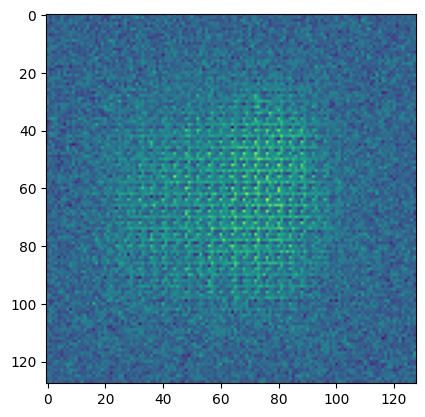

In [60]:
imshow(res[0,0,:,:,0])

In [34]:
res.shape

(3, 1, 128, 128, 1)

In [35]:

t0, t1 = 5., 0.
drift = lambda t, y, args: - 0.5 * score_fn(t/t0, y, model, params, state) # Now sigma is a function of time
diffusion = lambda t, y, args: jnp.ones_like(y)
solver = Euler()
saveat = SaveAt(ts=jnp.linspace(t0,t1))

@jax.jit
@jax.vmap
def get_samples(y, seed):
    brownian_motion = VirtualBrownianTree(t0, t1, tol=1e-4, shape=(), key=seed)
    terms = MultiTerm(ODETerm(drift), ControlTerm(diffusion, brownian_motion))
    return diffeqsolve(terms, solver, t0, t1, dt0=-0.001, y0=y, max_steps=10_000, saveat=saveat).ys

In [36]:
ref_samples = res+0

res = get_samples(
    ref_samples,
    jax.random.split(jax.random.PRNGKey(8), n_samples)
)

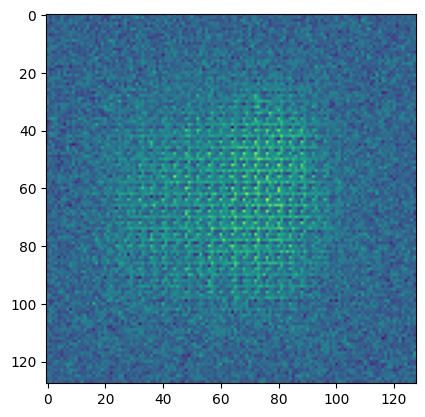

In [37]:
imshow(res[0,0,0,:,:,0])

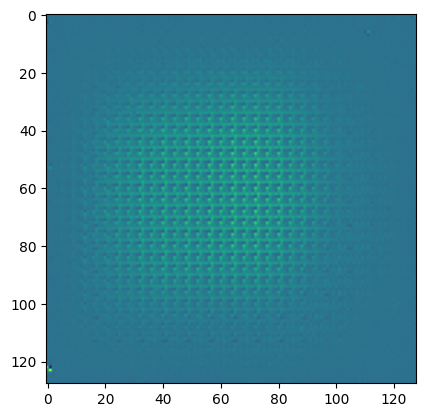

In [38]:
imshow(res[0,49,0,:,:,0])

In [39]:
res.shape

(3, 50, 1, 128, 128, 1)

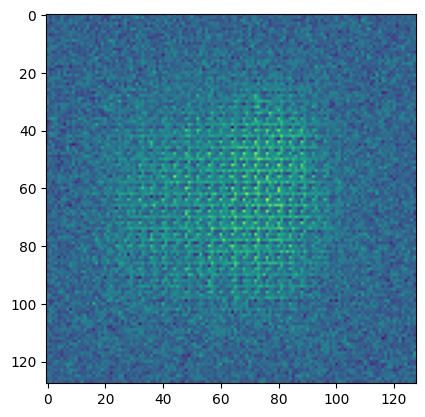

In [40]:
idx = 0
imshow(res[idx,0,0,:,:,0])

In [41]:
res.shape

(3, 50, 1, 128, 128, 1)

In [42]:
res[idx,1,0,:,:,0]

Array([[-0.23955275, -0.4111696 , -0.17304362, ..., -0.14609337,
        -0.08696953, -0.36775437],
       [ 0.01997809, -0.66787386, -0.10515675, ..., -0.03249608,
        -0.29873988, -0.18197565],
       [-0.03365967, -0.39324996, -0.07584544, ..., -0.20489803,
        -0.27843958, -0.31706506],
       ...,
       [-0.11680039, -0.09925447, -0.5175096 , ..., -0.26128042,
        -0.44932142, -0.38902393],
       [-0.41925195, -0.12589674, -0.3298862 , ..., -0.18037614,
        -0.1035331 , -0.14327605],
       [-0.28643602,  0.0702023 , -0.48992425, ..., -0.16214994,
        -0.0374734 , -0.40232828]], dtype=float32, weak_type=True)

In [43]:
res

Array([[[[[[-2.17152134e-01],
           [-4.10920620e-01],
           [-1.45480096e-01],
           ...,
           [-1.15296856e-01],
           [-4.69296686e-02],
           [-3.64462882e-01]],

          [[ 6.82871565e-02],
           [-6.94811285e-01],
           [-7.07683489e-02],
           ...,
           [ 8.53469037e-03],
           [-2.83375978e-01],
           [-1.55586377e-01]],

          [[ 2.92190723e-03],
           [-4.01521087e-01],
           [-3.97134982e-02],
           ...,
           [-1.84997723e-01],
           [-2.61240035e-01],
           [-3.05396318e-01]],

          ...,

          [[-8.02083313e-02],
           [-5.95179461e-02],
           [-5.26008368e-01],
           ...,
           [-2.40235731e-01],
           [-4.54484910e-01],
           [-3.85092944e-01]],

          [[-4.20905739e-01],
           [-9.99755859e-02],
           [-3.19089800e-01],
           ...,
           [-1.55317843e-01],
           [-6.66948557e-02],
           [-1.11842491e-0